# Info

Setting up the model to recreate the oscillating basin from the non-hydrostatic manual <br>
[Link to the manual](https://oss.deltares.nl/documents/4142077/4199062/non-hydrostatic_report_draft.pdf/eadc1aff-6e19-6e82-2747-3c11c30457ee?t=1624871720408)

In [109]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os
import subprocess

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

In [110]:
## import xbeach tools
#sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general.wave_functions import offshore_depth
from xbTools.xbeachpost import XBeachModelAnalysis


In [111]:
import numpy as np

# Linear dispersion function
def calc_dispersion_relation(k, g, H):
    r"""
    Purpose: Calc the dispersion relation for a wave using non-hydrostatic linearized
    Eqn: $$ k * \sqrt{\frac{gH}{1 + 0.25(kH)^{2}} $$
    where,

    k: wave number [rad/m]
    g: gravity
    H: Water depth at an x, y location
    """

    numerator = g * H
    denominator = 1 + 0.25 * (k * H)**2

    return k * np.sqrt(numerator/denominator)

def calc_wave_number(k_x, k_y):
    r"""
    Purpose: Calc the magnitude of the individual directional wave numbers
    In multidimensional systems, the wave number is the magnitude of the wave vector

    NOTE: Eqn. taken from Wave-current interaction (wci) XBeach manual section
    """
    return np.sqrt(k_x**2 + k_y**2)

def calc_surface_elevation(zeta_0, k_x, k_y, x, y, t, omega):
    r"""
    Purpose: Calc the surface elevation linear dispersion, formula taken from xBeach non-hydrostatic manual
    
    Eqn: $$ \zeta(x, y, t) = \zeta_{0} cos(k_{x} x) cos(k_{y} y) cos(\omega t) 

    \zeta:     Surface elevation
    \zeta_{0}: Initial surface displacement??
    k_{x}:     wave number in the x-direction
    k_{y}:     wave number in the y-direction
    x:         x-location
    y:         y-location
    t:         time
    omega:     linear dispersion
    """

    return zeta_0 * np.cos(k_x * x) * np.cos(k_y * y) * np.cos(omega * t)

# average velocity functions

# x-velocity
def calc_U_velocity(eta_0, g, k_x, k_y, H, x, y, t, omega):
    r"""
    Purpose: Calc the average U velocity using the relation provided in xBeach non-hydrostatic in the linear dispersion example

    Eqn: $$U(x, y, t) = \frac{\eta_{0} g k_{x}}{k H \omega} sin(k_{x} x) cos(k_{y} y) sin(\omega t)$$
     
    \eta_{0}: Initial water elevation
    g:        gravity
    k_{x}:    x-direction wave number
    k_{y}:    y-direction wave number
    H:        water depth
    x:        x-location
    y:        y-location
    t:        time
    \omega:   dispersion
    k:        wave number (magnitude of the individual componets)
    """
    k = calc_wave_number(k_x, k_y)

    frac = eta_0 * g * k_x/(k * H * omega)
    trig_part = np.sin(k_x * x) * np.cos(k_y * y) * np.sin(omega * t)

    return frac * trig_part

# y-velocity
def calc_V_velocity(eta_0, g, k_x, k_y, H, x, y, t, omega):
    r"""
    Purpose: Calc the average V velocity using the relation provided in xBeach non-hydrostatic in the linear dispersion example

    Eqn: $$V(x, y, t) = \frac{\eta_{0} g k_{y}}{k H \omega} cos(k_{x} x) sin(k_{y} y) sin(\omega t)$$

    \eta_{0}: Initial water elevation
    g:        gravity
    k_{x}:    x-direction wave number
    k_{y}:    y-direction wave number
    H:        water depth
    x:        x-location
    y:        y-location
    t:        time
    \omega:   dispersion
    k:        wave number (magnitude of the individual componets)
    """

    # Calc the magnitude of the wave number vector
    k = calc_wave_number(k_x, k_y)

    frac = eta_0 * g * k_y/(k * H * omega)

    trig_part = np.cos(k_x * x) * np.sin(k_y * y) * np.sin(omega * t)

    return frac * trig_part
    
def find_closest_value_index(arr, value):
    # Purpose find the index of the closest number in arr to value
    
    diff_arr = np.abs(arr - value)
    index = diff_arr.argmin()

    return index

def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path


In [112]:
L = 100 # Length, [m]
g = 9.81 # gravity, [m/s^2]

# wave numbers for the different directions
k_x = PI/L
k_y = PI/L

k = calc_wave_number(k_x, k_y)

relative_depth = 0.5 # k/H 

H = k/relative_depth # Water depth, [m]

# Using the period from desmos (two subquential upcrossings) 
wave_period = 153.28

omega = calc_dispersion_relation(k, g, H) # Dispersion relation, angular velocity

print("Still water depth (H): {:.2f}".format(H))
print("Directional wave numbers, x: {:.2f}, y: {:.2f} ".format(k_x, k_y))
print("Wave number magnitude: {:.3f}".format(k))
print("Depth: {:.3f}".format(H))
print("Dispersion relation: {:.3f}".format(omega))

Still water depth (H): 0.09
Directional wave numbers, x: 0.03, y: 0.03 
Wave number magnitude: 0.044
Depth: 0.089
Dispersion relation: 0.041


### Data
Generate and plot the bathymetry

In [113]:
# Set bathy grid
nx = ny = 100

# Construct the x-coordinates
x = np.linspace(0, L, nx + 1)

# Construct the y-coordinates
y = np.linspace(0, L, ny + 1)

# Generate the grid
xgr, ygr = np.meshgrid(x, y)

# Calc the bathymetry as -H
zgr = np.ones((nx + 1, ny + 1)) * -H

In [114]:
print(zgr.shape)
print(xgr.shape)
print(ygr.shape)

(101, 101)
(101, 101)
(101, 101)


In [115]:
# Specify the filename
filename = 'x.grd'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write each row of the array to the file
    for row in xgr:
        file.write(' '.join(map(str, row)) + '\n')

print(f"2D array values have been written to {filename}")

2D array values have been written to x.grd


In [116]:
# Specify the filename
filename = 'y.grd'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write each row of the array to the file
    for row in ygr:
        file.write(' '.join(map(str, row)) + '\n')

print(f"2D array values have been written to {filename}")

2D array values have been written to y.grd


In [117]:
# Specify the filename
filename = 'bed.dep'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write each row of the array to the file
    for row in zgr:
        file.write(' '.join(map(str, row)) + '\n')

print(f"2D array values have been written to {filename}")


2D array values have been written to bed.dep


In [118]:
# Get the folder of the current script
model_dir = get_script_directory()

print("Model directory is: {}".format(model_dir))

Model directory is: c:\ERDC\tutorial_models\oscillating_basin\3_oscillating_tstop_10_nxy_100


In [119]:
# Specify the path to your batch file
batch_file = os.path.join(model_dir, r"run_model.bat")

# Run the batch file
try:
    subprocess.run(batch_file, check=True, shell=True)
    print(f"Batch file '{batch_file}' executed successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred while executing the batch file: {e}")

Batch file 'c:\ERDC\tutorial_models\oscillating_basin\3_oscillating_tstop_10_nxy_100\run_model.bat' executed successfully.


In [120]:
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

results.set_save_fig(False)
results.set_plot_localcoords(False)
results.set_plot_km_coords(False)

loading variable zs from file
loading variable zb from file


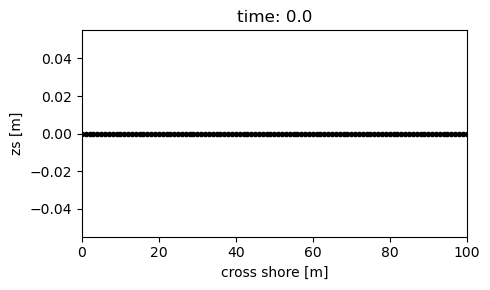

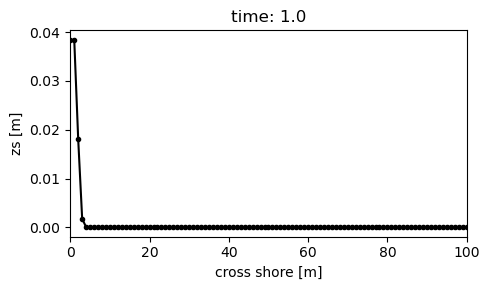

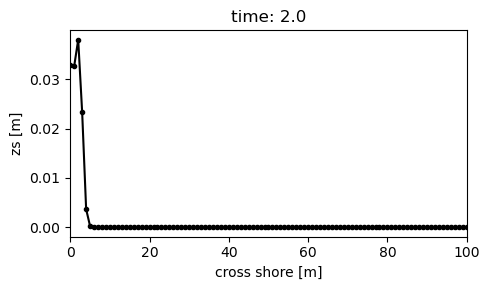

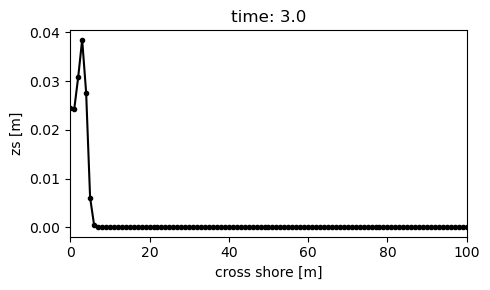

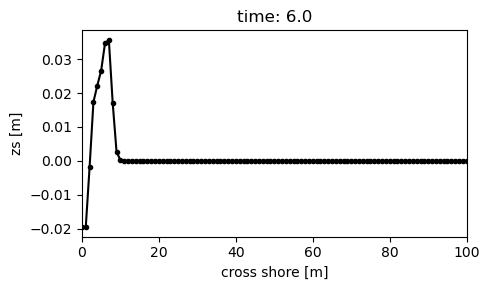

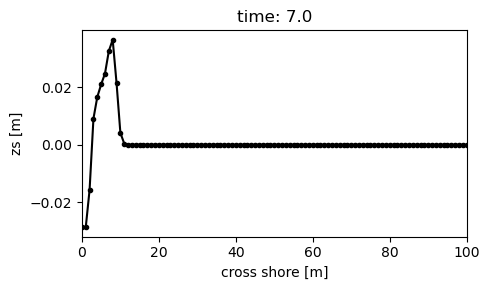

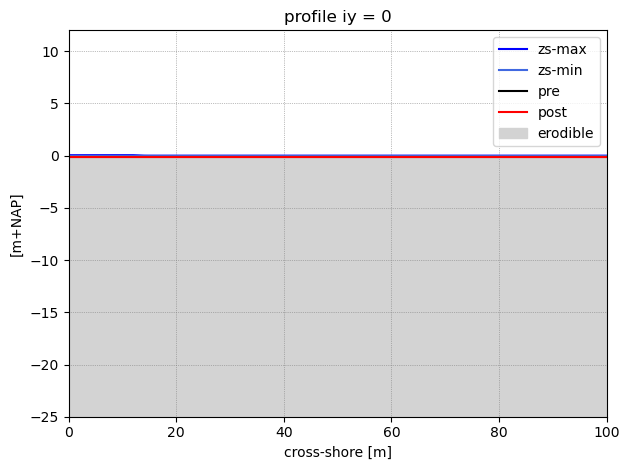

In [121]:
indices = [0, 10, 20, 30, 60, 70]

for index in indices:
    fig, ax = results.fig_cross_var('zs', index, iy=10, coord=None, plot_ref_bathy=False, zmin=-1)

fig, ax = results.fig_profile_change(iy=0)

(101, 101, 101)


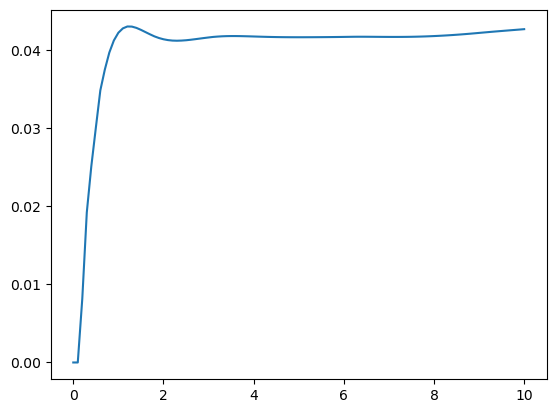

In [122]:
time = results.var["globaltime"]

zs = results.var["zs"]
print(np.shape(zs))

zs_0 = results.var["zs"][:, 0, 0]
plt.plot(time, zs_0)


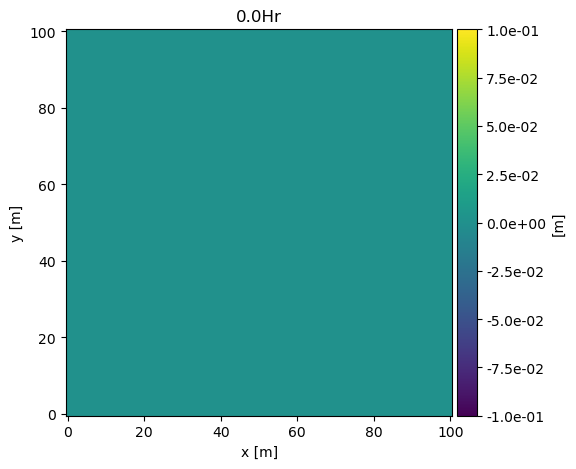

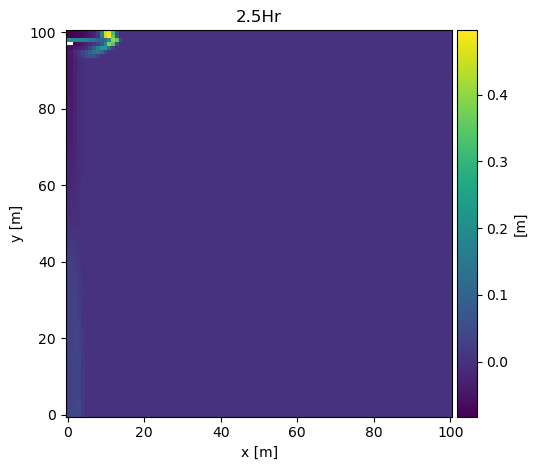

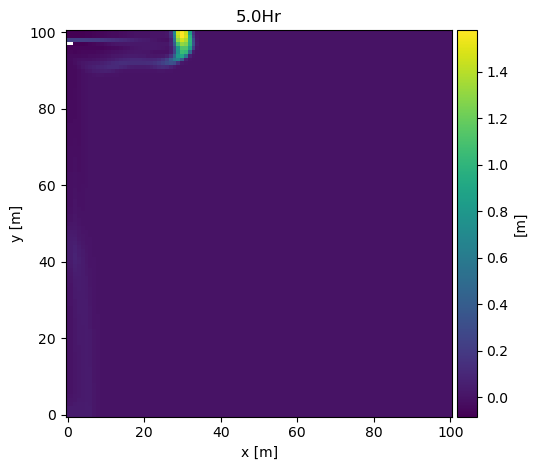

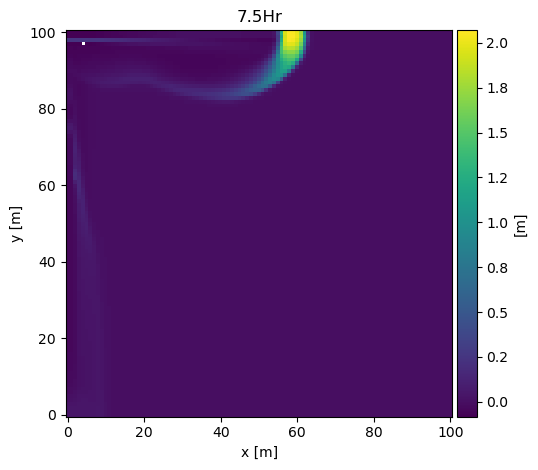

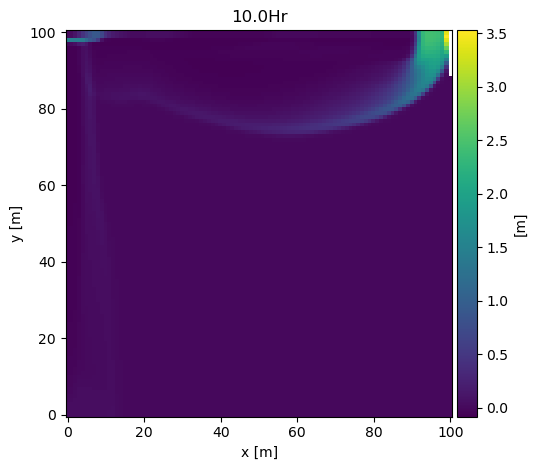

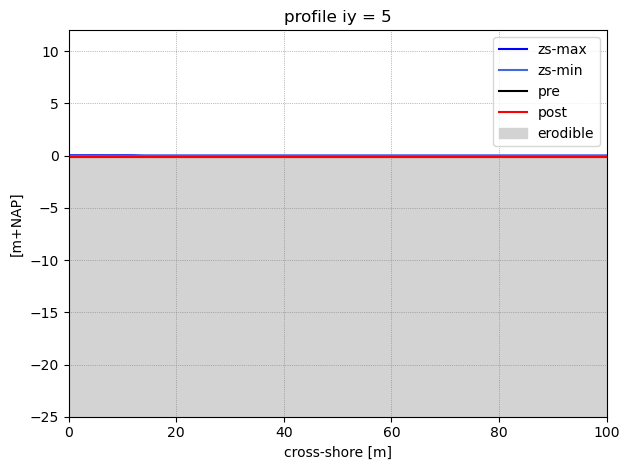

In [130]:
## change coordinates of plots to local coordinates:
#results.set_plot_localcoords(True)
## only plot a certain Area Of Interest of the complete grid
#results.set_aoi([20,445,20,220])

# example usage map plotting

indices = [0, 25, 50, 75, 100]
for index in indices:
    fig, ax = results.fig_map_var('zs','[m]', it = index)

#fig, ax = results.fig_map_diffvar('zb', '$\Delta z_b$ [m]')

# fig, ax = results.fig_cross_var('H', 2, iy=5, coord=None, plot_ref_bathy=True, zmin=-25)

fig, ax = results.fig_profile_change(iy=5)